In [1]:
import os, sys
project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

sparse_dir = os.path.join(project_dir, 'modules/Sparse')
if sparse_dir not in sys.path:
    sys.path.append(sparse_dir)

import numpy as np
import torch
from torch import nn

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor

In [2]:
transform = Compose([ToTensor()])
dataset = MNIST('dataset/', train=True, transform=transform, download=True)

loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [3]:
import AttentionMap

model = nn.Sequential(*[
    AttentionMap.Conv2d(1, 4, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),
    AttentionMap.Conv2d(4, 12, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),
    nn.Flatten(start_dim=1),
    nn.Linear(588, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 32),
    nn.ReLU(inplace=True),
    nn.Linear(32, 10),
    # nn.LogSoftmax(dim=1)
])

In [4]:
from tqdm import tqdm

n_epoch = 20
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

epoch_iterator = tqdm(
        range(n_epoch),
        leave=True,
        unit="epoch",
        postfix={"tls": "%.4f" % 1},
    )

for epoch in epoch_iterator:
    for idx, (input, target) in enumerate(loader):
        input = input.to(device)
        target = target.to(device)

        out = model(input)
        loss = criterion(out, target)

        if idx % 500 == 0:
            epoch_iterator.set_postfix(tls="%.4f" % np.mean(loss.detach().item()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 20/20 [04:14<00:00, 12.73s/epoch, tls=0.0624]


In [12]:
am = model[0]
att = am.attention_map(input.to(device))[0].detach().cpu()
conv = am.conv(input.to(device))[0].detach().cpu()
result = am(input.to(device))[0].detach().cpu()

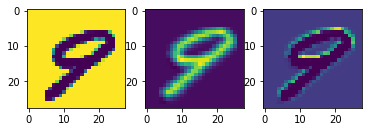

In [13]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,3)
ax[0].imshow(att[0].detach().cpu())
ax[1].imshow(conv[0].detach().cpu())
ax[2].imshow(result[0].detach().cpu())

In [7]:
input_lvl3 = model[:3](input.to(device))
am = model[3]
att = am.attention_map(input_lvl3.to(device))[0].detach().cpu()
conv = am.conv(input_lvl3.to(device))[0].detach().cpu()
result = am(input_lvl3.to(device))[0].detach().cpu()

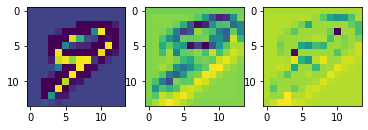

In [8]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,3)
ax[0].imshow(att[0].detach().cpu())
ax[1].imshow(conv[2].detach().cpu())
ax[2].imshow(result[2].detach().cpu())

(array([ 45.,   6.,   3.,   4., 114.,   3.,   2.,   0.,   0.,   0.,   1.,
          2.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,
          2.,   2.,   9.]),
 array([1.6598379e-18, 1.9790381e-02, 3.9580762e-02, 5.9371144e-02,
        7.9161525e-02, 9.8951906e-02, 1.1874229e-01, 1.3853267e-01,
        1.5832305e-01, 1.7811343e-01, 1.9790381e-01, 2.1769419e-01,
        2.3748457e-01, 2.5727496e-01, 2.7706534e-01, 2.9685572e-01,
        3.1664610e-01, 3.3643648e-01, 3.5622686e-01, 3.7601724e-01,
        3.9580762e-01, 4.1559801e-01, 4.3538839e-01, 4.5517877e-01,
        4.7496915e-01, 4.9475953e-01], dtype=float32),
 <BarContainer object of 25 artists>)

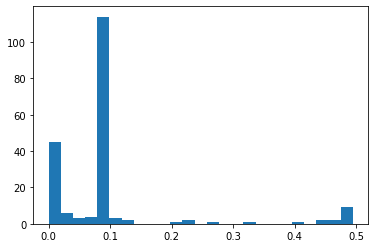

In [10]:
plt.hist(att[0].cpu().flatten().detach().numpy(), bins=25)